In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
import numpy as np
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"]="0";   

# Text Classification with Hugging Face Transformers in *ktrain*

As of v0.8.x, *ktrain* now includes an easy-to-use, thin wrapper to the Hugging Face transformers library for text classification.

## Load Data Into Arrays

In [6]:
NEWS_PATH = '../news_scraper/news_articles'

In [7]:
x = []
y = []

for topic in os.listdir(NEWS_PATH):
    for stance in os.listdir(os.path.join(NEWS_PATH, topic)):
        for file in os.listdir(os.path.join(NEWS_PATH, topic, stance)):
            with open(os.path.join(NEWS_PATH, topic, stance, file), 'r') as f:
                x.append(f.read())
            y.append(stance)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(f'Size of training set: {len(x_train)}')
print(f'Size of test set: {len(x_test)}')

Size of training set: 3610
Size of test set: 1204


## STEP 1: Preprocess Data and Build a Transformer Model

For `MODEL_NAME`, *ktrain* supports both the "official" built-in models [available here](https://huggingface.co/transformers/pretrained_models.html) and the [community-upoaded models available here](https://huggingface.co/models).

In [9]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

preprocessing train...
language: en
train sequence lengths:
	mean : 816
	95percentile : 2080
	99percentile : 3881


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 812
	95percentile : 2037
	99percentile : 4380


Note that `x_train` and `x_test` are the raw texts that look like this:
```python
x_train = ['I hate this movie.', 'I like this movie.']
```
The labels are arrays in one of the following forms:
```python
# string labels
y_train = ['negative', 'positive']
# integer labels
y_train = [0, 1]
# multi or one-hot encoded labels
y_train = [[1,0], [0,1]]
```
In the latter two cases, you must supply a `class_names` argument to the `Transformer` constructor, which tells *ktrain* how indices map to class names.  In this case, `class_names=['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']` because 0=alt.atheism, 1=comp.graphics, etc.

## STEP 2 [Optional]: Estimate a Good Learning Rate

Learning rates between `2e-5` and `5e-5` tend to work well with transformer models based on papers from Google. However, we will run our learning-rate-finder for two epochs to estimate the LR on this particular dataset.

As shown below, our results are consistent Google's findings.

simulating training for different learning rates... this may take a few moments...
Train for 601 steps
Epoch 1/2
601/601 [==============================] - 224s 373ms/step - loss: 1.0982 - accuracy: 0.3566
Epoch 2/2
601/601 [==============================] - 219s 364ms/step - loss: 1.3231 - accuracy: 0.3282


done.
Visually inspect loss plot and select learning rate associated with falling loss


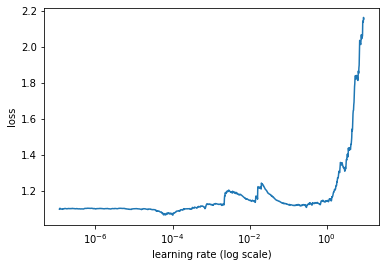

In [10]:
learner.lr_find(show_plot=True, max_epochs=2)

## STEP 3: Train Model

Train using a [1cycle learning rate schedule](https://arxiv.org/pdf/1803.09820.pdf).

In [11]:
learner.fit_onecycle(8e-5, 4)



begin training using onecycle policy with max lr of 8e-05...
Train for 602 steps, validate for 38 steps
Epoch 1/4
602/602 [==============================] - 244s 405ms/step - loss: 1.0211 - accuracy: 0.4429 - val_loss: 0.8836 - val_accuracy: 0.5507
Epoch 2/4
602/602 [==============================] - 243s 404ms/step - loss: 0.8413 - accuracy: 0.6183 - val_loss: 0.9037 - val_accuracy: 0.6130
Epoch 3/4
602/602 [==============================] - 244s 405ms/step - loss: 0.6545 - accuracy: 0.7213 - val_loss: 0.6449 - val_accuracy: 0.7334
Epoch 4/4
602/602 [==============================] - 244s 405ms/step - loss: 0.3073 - accuracy: 0.8825 - val_loss: 0.6787 - val_accuracy: 0.7458


## STEP 4: Evaluate/Inspect Model

In [12]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

      center       0.76      0.79      0.77       380
        left       0.74      0.73      0.73       407
       right       0.74      0.72      0.73       417

    accuracy                           0.75      1204
   macro avg       0.75      0.75      0.75      1204
weighted avg       0.75      0.75      0.75      1204



array([[301,  40,  39],
       [ 45, 298,  64],
       [ 52,  66, 299]])

In [13]:
# the one we got most wrong
learner.view_top_losses(n=1, preproc=t)

----------
id:1190 | loss:5.51 | true:center | pred:left)



In [14]:
# understandable mistake - this sci.med post talks a lot about computer graphics
print(x_test[1190])

Disinformation is propaganda. It can also be incredibly effective, even when we know it's not true.

Almost 15 years after Stephen Colbert introduced the term "truthiness" into the modern lexicon, news consumers find themselves awash in a deluge of misinformation, fake news, and alternative facts. The problem is two-fold: if disinformation fits their already established worldview, people believe it. At the same time, if disinformation doesn't fit their worldview, it affects people's views of those sharing it. Either way, it contributes to widespread political divisiveness and pits Americans against each other.

At this point, we're all familiar with the prevalence of misinformation online. For instance, as the Australian bushfires raged, the hashtag #arsonemergency blamed arson — not climate change — for the blazes. Researchers at Queensland University of Technology identified that many of the accounts pushing the arson narrative were trolls or bots. During the 2016 election, the Russi

## STEP 5: Make Predictions on New Data in Deployment

In [23]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [95]:
from newspaper import Article
art = Article('https://www.foxnews.com/media/gutfeld-guests-say-trump-was-comedic-genius-at-tulsa-rally-while-pence-lacked-razzmatazz')
art.download()
art.parse()

probs = sum(predictor.predict_proba([art.text, art.text[10:], art.text[20:], art.text[30:]])) / 4
mn = [0, -1, 1]
print(probs)
print(probs * mn)
print(sum(probs * mn))

[0.14560685 0.02474763 0.82964545]
[ 0.         -0.02474763  0.82964545]
0.804897828027606


In [70]:
predictor.get_classes()

['center', 'left', 'right']

In [97]:
predictor.save('./news_bias_predictor')

In [14]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_20newsgroup_predictor')

In [15]:
reloaded_predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [16]:
reloaded_predictor.predict_proba('Jesus Christ is the central figure of Christianity.')

array([1.9110834e-03, 5.9577124e-04, 4.4542018e-04, 9.9704772e-01],
      dtype=float32)

In [17]:
reloaded_predictor.get_classes()

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']